# Strain and Voltage During Formation

Iaroslav Kovalchuk, Andrew Weng

2022/11/28

In [1]:
## Import all diferent libraries
import os, sys

if os.path.basename(os.getcwd()) == 'notebooks':
    os.chdir('../')
    sys.path.insert(0, 'src/')

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from src import plotter as plotter


# Initialize Paths

In [2]:
plotter.initialize(plt)
target_dir = os.getcwd()
target_dir_arbin = f'{target_dir}/data/raw/from-voltaiq'
file_indices_to_include = np.array([1])

cellid = 152074

if cellid == 152098: # FAST FORMATION 2

    file_arbin_list = [
        f'{target_dir_arbin}/UMBL2022FEB_CELL152098_FORMTAP_2_P45C_5P0PSI_20220901_R1.csv',
        f'{target_dir_arbin}/UMBL2022FEB_CELL152098_FORMFAST_2_P45C_5P0PSI_20220902_R1.csv',
        f'{target_dir_arbin}/UMBL2022FEB_CELL152098_FORMAGING_1_P45C_5P0PSI_20220909_R1.csv',
        f'{target_dir_arbin}/UMBL2022FEB_CELL152098_CYC_1C1CR1_P45C_5P0PSI_20220923_R1.csv'
                    ]

    daq_channel = 'Key_CH2'

    hr_max = 6

elif cellid == 152064: # BASELINE FORMATION (repeat 1)

    file_arbin_list = [
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_FORMTAP_2_P45C_5P0PSI_20220901_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_FORMBASE_1_P45C_5P0PSI_20220902_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_FORMAGING_1_P45C_5P0PSI_20220909_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152064_CYC_1C1CR1_P45C_5P0PSI_20220923_R1.csv'
                    ]

    daq_channel = 'Key_CH1'

    hr_max = 65


elif cellid == 152071: # FAST FORMATION 1

    file_arbin_list = [
    f'{target_dir_arbin}/UMBL2022FEB_CELL152071_FORMTAP_2_P45C_5P0PSI_20220901_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152071_FORMFAST_1_P45C_5P0PSI_20220902_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152071_FORMAGING_1_P45C_5P0PSI_20220909_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152071_CYC_1C1CR1_P45C_5P0PSI_20220923_R1.csv'
                    ]

    daq_channel = 'Key_CH3'

    hr_max = 16


elif cellid == 152074: # BASELINE FORMATION (repeat 2)

    file_arbin_list = [
    f'{target_dir_arbin}/UMBL2022FEB_CELL152074_FORMTAP_2_P45C_5P0PSI_20220901_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152074_FORMBASE_1_P45C_5P0PSI_20220902_R1.csv',
    f'{target_dir_arbin}/UMBL2022FEB_CELL152074_FORMAGING_1_P45C_5P0PSI_20220909_R1.csv',
                    ]

    daq_channel = 'Key_CH0'

    hr_max = 65



# Load the Arbin Data

In [3]:
df_arbin_list = []

for file in np.array(file_arbin_list)[file_indices_to_include]:

    df = pd.read_csv(file)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df['Timestamp']= df['Timestamp'].apply(lambda x : x.tz_localize(None))
    df_arbin_list.append(df)

df_arbin = pd.concat(df_arbin_list, axis=0)


# Load the Keyence Data

In [4]:
# Load the Keyence data
file_keyence = f'{target_dir}/data/raw/from-keyence/keyence_20220901_213928.csv'
df_keyence = pd.read_csv(file_keyence)
df_keyence['computer time'] = pd.to_datetime(df_keyence['computer time'], unit='s')
df_keyence['computer time'] = df_keyence['computer time'].apply(lambda x : x.tz_localize(None))

# Filter the Keyence data
df_keyence = df_keyence.loc[(df_keyence['computer time'] > df_arbin['Timestamp'].iloc[0]) & \
                            (df_keyence['computer time'] < df_arbin['Timestamp'].iloc[-1])]
y_strain = df_keyence[daq_channel] - df_keyence[daq_channel].iloc[0]
y_strain[y_strain > 500] = np.NaN


# Visualize the results

/var/folders/qr/bx1pzh1x6nnbdrjvw2qhqkf40000gn/T/ipykernel_79128/995992803.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_voltage.iloc[np.where(tt > hr_max)] = np.NaN


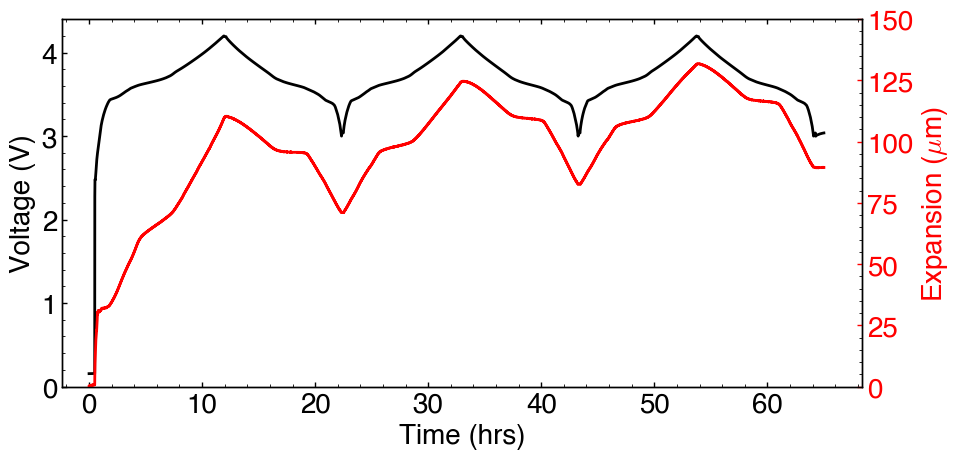

In [5]:
plt.figure(figsize=(10,5))

# The voltage plot
ax1 = plt.subplot()

tt = df_arbin['Timestamp'].astype(int)
tt = (tt - np.min(tt)) / 3600 / 1e9
y_voltage = df_arbin['Potential (V)']

y_voltage.iloc[np.where(tt > hr_max)] = np.NaN

ax1.plot(tt, y_voltage, color='k')
ax1.set_xlabel('Time (hrs)')
ax1.set_ylabel('Voltage (V)')
ax1.set_ylim(bottom=0)
ax1.grid(False)
ax1.set_xlim((-0.1 * 24, 2.85 * 24))

# The expansion plot
ax2 = ax1.twinx()

tt = df_keyence['computer time'].astype(int)
tt = (tt - np.min(tt)) / 3600 / 1e9

y_strain.iloc[np.where(tt > hr_max)] = np.NaN

ax2.plot(tt, y_strain, color='r')
ax2.set_ylabel(r'Expansion ($\mu$m)')
ax2.tick_params(axis='y', colors='r')
ax2.yaxis.label.set_color('red')
ax2.set_ylim(bottom=0, top=150)
ax2.grid(False)

plt.savefig(f'outputs/figures/fig_strain_vs_voltage_cell{cellid}.png', dpi=300)
